# Creating Container for Simulated Data
In this notebook, I want to derive a HDF5 container for a given simulated network (simulated by `NetSim`). For that, I have to create simulated feature vectors and a training and test split.
The results should then be put in a HDF5 container.

In [21]:
import pandas as pd
import networkx as nx
import numpy as np
import h5py, os, sys
np.set_printoptions(precision=1, suppress=True)
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../GCN'))
import gcnPreprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
# params
test_ratio = .3
pos_distr = (50, 60) # mean and variance
neg_distr = (45, 60) # mean and variance
num_features = 24
NETWORK_TYPE = 'clique'

## Load Network and Insert Positions from Disk

In [74]:
if NETWORK_TYPE == 'random':
    if not os.path.exists('../data/simulation/random_network/network.edgelist'):
        for i in range(1, 1000):
            G = nx.barabasi_albert_graph(n=1000, m=i)
            if nx.number_of_edges(G) > 1500:
                break
        nx.write_edgelist(G, '../data/simulation/random_network/network.edgelist')
        x = list(np.random.choice(list(nx.nodes(G)), size=190).reshape(-1, 5))
        insert_positions = [list(i) for i in x]
        network = G
        with open('../data/simulation/random_network/insert_positions.txt', 'w') as f:
                count = 1
                f.write('# subnetwork insert positions. Each row corresponds to a subnetwork and each column to a position in it.\n')
                for m in insert_positions:
                    f.write('Subnetwork {}: '.format(count))
                    for i in m:
                        f.write('{}\t'.format(i))
                    f.write('\n')
                    count += 1
    else:
        network = nx.read_edgelist('../data/simulation/random_network/network.edgelist')
        insert_positions = []
        with open('../data/simulation/random_network/insert_positions.txt', 'r') as f:
            for line in f.readlines():
                if line.startswith('#'): # comment
                    pass
                elif line.startswith('Subnetwork'):
                    positions = line.split(':')[1].strip().split('\t')
                    insert_positions.append([int(i) for i in positions])

elif NETWORK_TYPE == 'star':
    # read the network and insert positions
    network = nx.read_edgelist('../data/simulation/star_network/network.edgelist')
    insert_positions = []
    with open('../data/simulation/star_network/insert_positions.txt', 'r') as f:
        for line in f.readlines():
            if line.startswith('#'): # comment
                pass
            elif line.startswith('Subnetwork'):
                positions = line.split(':')[1].strip().split('\t')
                insert_positions.append([int(i) for i in positions])
    print (network.number_of_nodes(), network.number_of_edges())

elif NETWORK_TYPE == 'clique':
    # read the network and insert positions
    network = nx.read_edgelist('../data/simulation/clique_network/network.edgelist')
    insert_positions = []
    with open('../data/simulation/clique_network/implant_positions.txt', 'r') as f:
        for line in f.readlines():
            if line.startswith('#'): # comment
                pass
            elif line.startswith('Subnetwork'):
                positions = line.split(':')[1].strip().split('\t')
                insert_positions.append([int(i) for i in positions])
    print (network.number_of_nodes(), network.number_of_edges())

else:
    print ("Network type {} not recognized.".format(NETWORK_TYPE))

1053 2275


In [75]:
# look for cliques in the network (sanity check for clique network only)
list_of_cliques = list(nx.find_cliques(network))
count = 0
for c in list_of_cliques:
    c_i = [int(j) for j in c]
    for i in insert_positions:
        if set(c_i) == set(i):
            count += 1
print ("Found {} cliques in insert positions and in the network".format(count))

Found 38 cliques in insert positions and in the network


## Assign Feature Vector

In [76]:
num_nodes = network.number_of_nodes()
all_motif_nodes = np.array(insert_positions).reshape(-1)
features = np.random.normal(loc=neg_distr[0], scale=np.sqrt(neg_distr[1]),
                            size=(num_nodes, num_features))
features[all_motif_nodes] = np.random.normal(loc=pos_distr[0], scale=np.sqrt(pos_distr[1]),
                                              size=(all_motif_nodes.shape[0], num_features))
not_motif_mems = np.array([i for i in np.arange(num_nodes) if not i in all_motif_nodes])
features[features < 0] = 0 # no negative gene expression

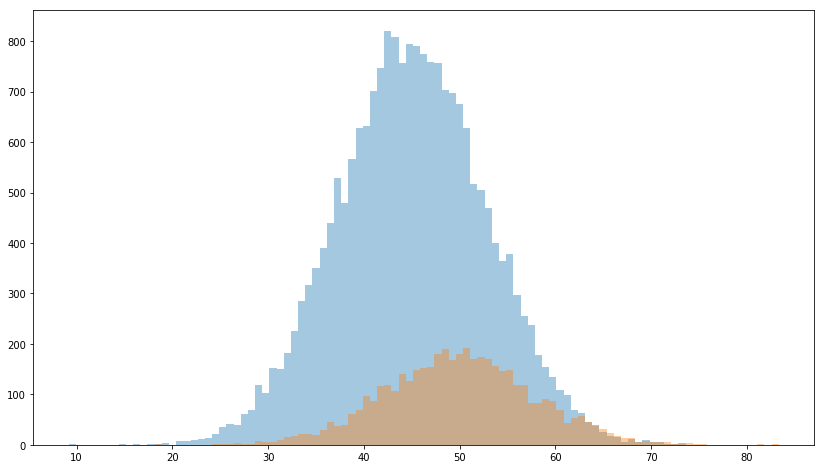

In [77]:
bins = np.linspace(features.min(), features.max(), 100)
fig = plt.figure(figsize=(14, 8))
sns.distplot(features[not_motif_mems].reshape(-1), bins=bins, label='Not in Graph Motifs',
             kde=False)
sns.distplot(features[all_motif_nodes].reshape(-1), bins=bins, label='Not in Graph Motifs',
             kde=False)

/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


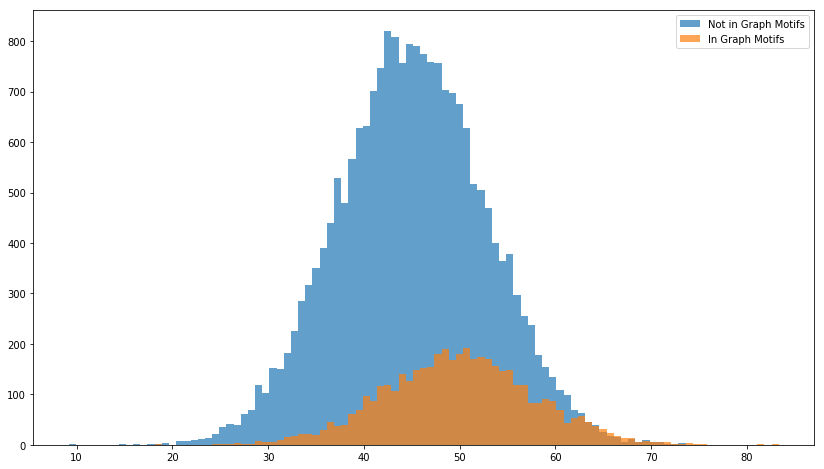

In [78]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[not_motif_mems].reshape(-1), bins=bins, label='Not in Graph Motifs',
             normed=False, alpha=.7)
_ = plt.hist(features[all_motif_nodes].reshape(-1), bins=bins, label='In Graph Motifs',
             normed=False, alpha=.7)
_ = plt.legend()
fig.savefig('../data/simulation/random_network/prob_distro_similar.svg')

## Compute Split

In [79]:
y = np.array([1 if i in all_motif_nodes else 0 for i in np.arange(num_nodes)]).reshape(-1, 1)
mask = np.ones(num_nodes, dtype=np.uint8)

In [80]:
import collections
collections.Counter(np.arange(num_nodes)[y[:, 0] == 1]) == collections.Counter(all_motif_nodes)

True

In [81]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.sum(), train_mask.sum(), y_test.sum(), test_mask.sum(), y_val.sum(), val_mask.sum()

(128, 710, 48, 264, 14, 79)

/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Training Features Distribution')

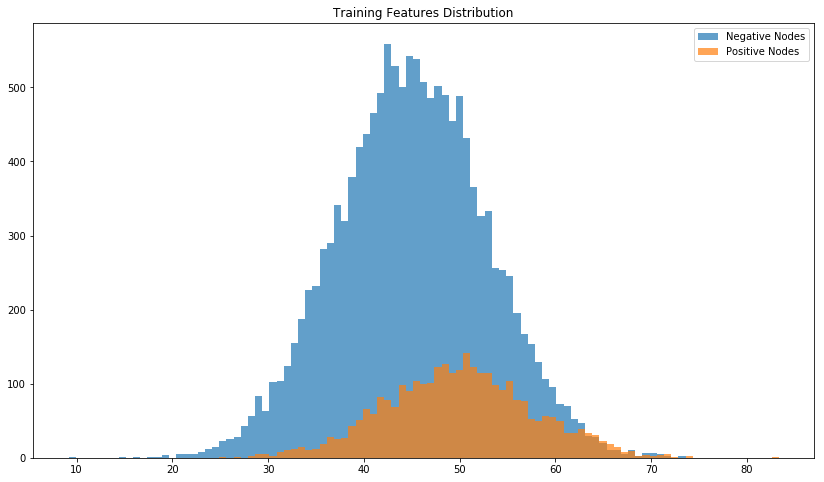

In [82]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = plt.hist(features[np.logical_and(y_train[:, 0] == 0, train_mask)].reshape(-1), bins=bins,
             label='Negative Nodes', normed=False, alpha=.7)
_ = plt.hist(features[np.logical_and(y_train[:, 0] == 1, train_mask)].reshape(-1), bins=bins,
             label='Positive Nodes', normed=False, alpha=.7)
_ = plt.legend()
plt.title('Training Features Distribution')

Text(0.5, 1.0, 'Test Features Distribution')

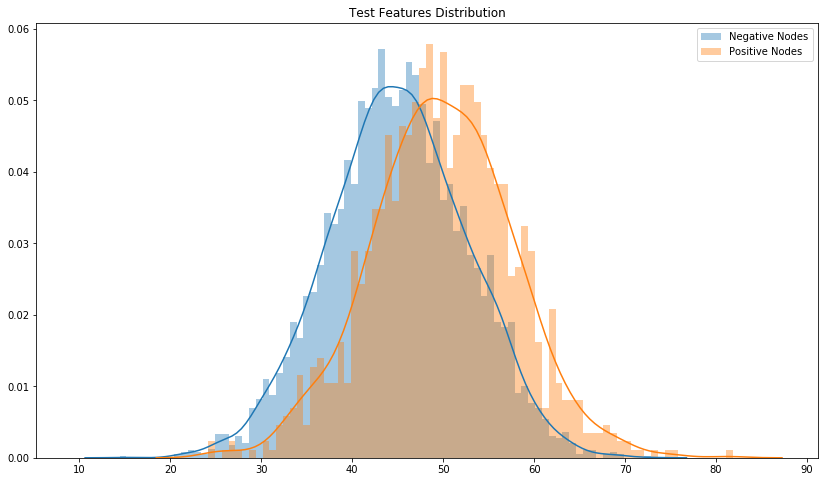

In [83]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(features.min(), features.max(), 100)
_ = sns.distplot(features[np.logical_and(y_test[:, 0] == 0, test_mask)].reshape(-1), bins=bins,
             label='Negative Nodes')
_ = sns.distplot(features[np.logical_and(y_test[:, 0] == 1, test_mask)].reshape(-1), bins=bins,
             label='Positive Nodes')
_ = plt.legend()
plt.title('Test Features Distribution')

## Write to HDF5 container

In [65]:
node_names = np.arange(num_nodes)
node_names = np.vstack([node_names, node_names]).transpose(1, 0) # just stack node numbers
node_names

array([[   0,    0],
       [   1,    1],
       [   2,    2],
       ...,
       [1050, 1050],
       [1051, 1051],
       [1052, 1052]])

In [84]:
network_np = nx.to_numpy_matrix(network, nodelist=[str(i[0]) for i in node_names])
node_names = np.arange(num_nodes)
node_names = np.vstack([node_names, node_names]).transpose(1, 0) # just stack node numbers

string_dt = h5py.special_dtype(vlen=str)

f = h5py.File('../data/simulation/clique_network/simulated_all_unbalanced_similar.h5', 'w')
f.create_dataset('network', data=network_np, shape=network_np.shape)
f.create_dataset('features', data=features, shape=features.shape)
f.create_dataset('gene_names', data=node_names, shape=node_names.shape)

f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_val', data=y_val, shape=y_val.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
f.create_dataset('feature_names', data=np.array(np.arange(features.shape[1]), dtype=object), dtype=string_dt)
f.create_dataset('features_raw', data=features, shape=features.shape)
f.close()

## Make sure that Data is Correct

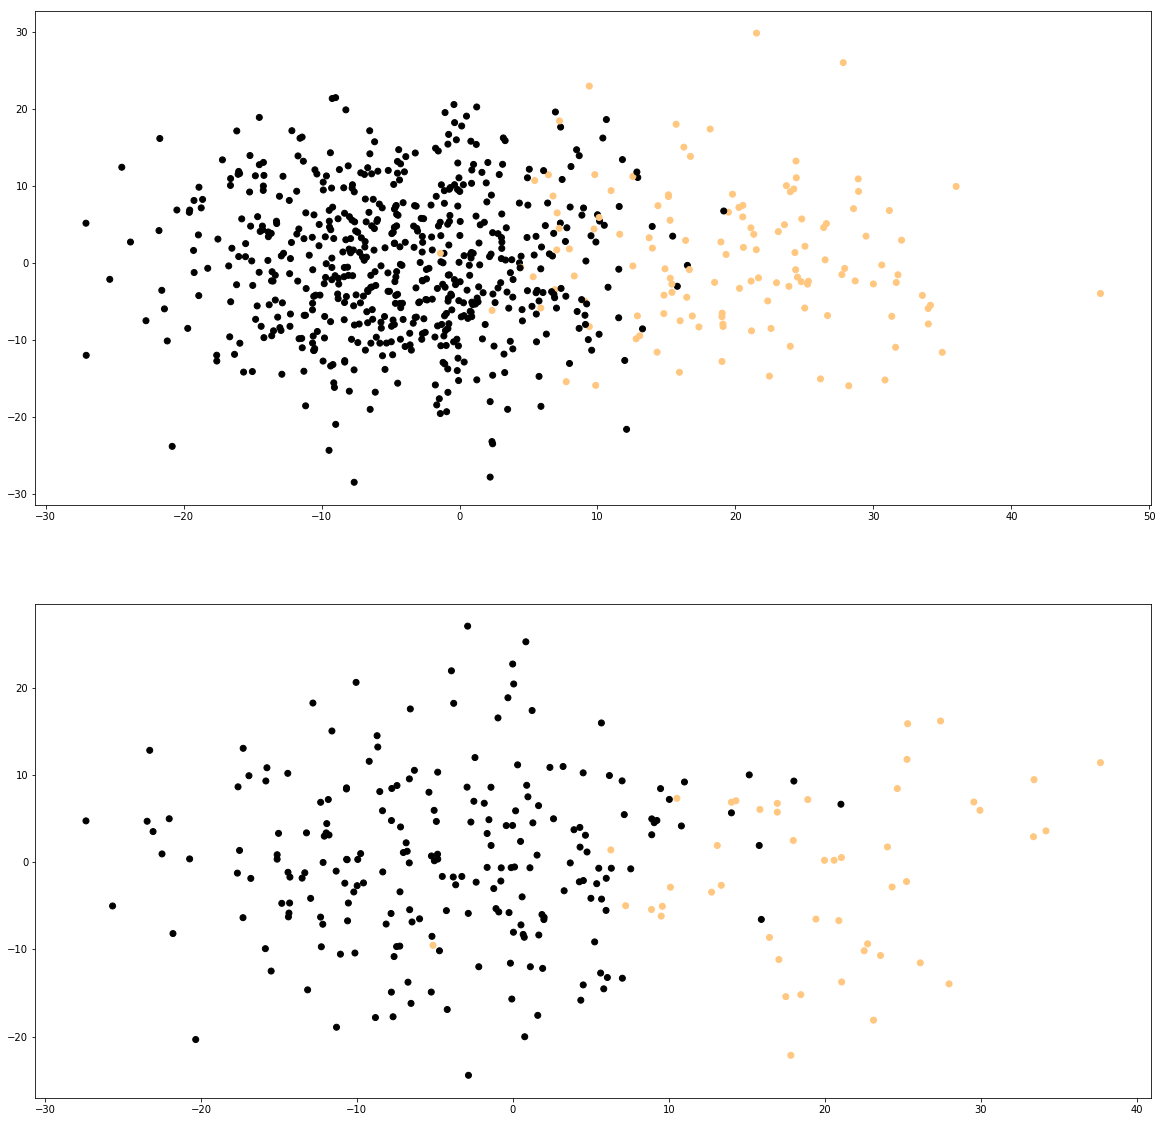

In [85]:
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
F_train = features[train_mask == 1]
emb = PCA(n_components=2).fit_transform(F_train)
plt.scatter(emb[:, 0], emb[:, 1], c=y_train[train_mask == 1, 0], cmap=plt.cm.copper)

plt.subplot(2, 1, 2)
F_test = features[test_mask == 1]
emb = PCA(n_components=2).fit_transform(F_test)
plt.scatter(emb[:, 0], emb[:, 1], c=y_test[test_mask == 1, 0], cmap=plt.cm.copper)

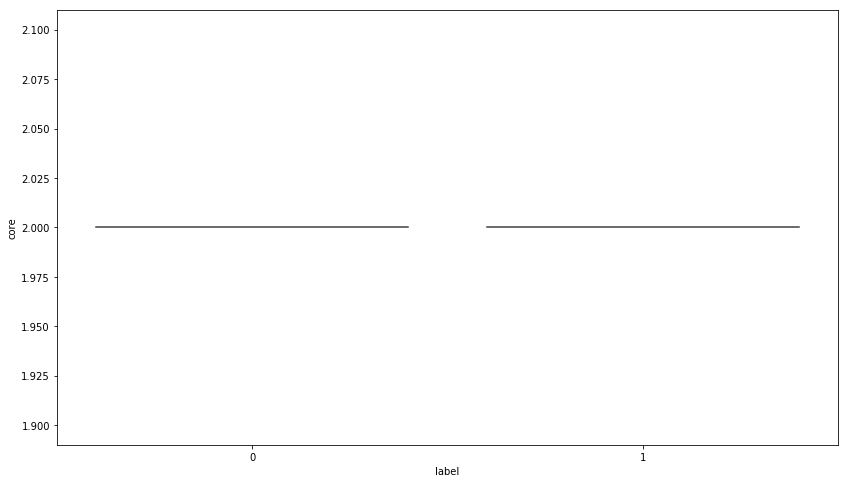

In [44]:
df = pd.DataFrame(features)
df[y == 1].mean().mean(), df[y == 1].var().mean()
df[y == 0].mean().mean(), df[y == 0].var().mean()
df['degree'] = network_np.sum(axis=1)
df['label'] = y

# get betweenness
bet = nx.betweenness_centrality(network)
df['betweenness'] = 0
for k, v in bet.items():
    df.loc[int(k), 'betweenness'] = v

# get core number
core = nx.core_number(network)
df['core'] = 0
for k, v in core.items():
    df.loc[int(k), 'core'] = v

# plot
fig = plt.figure(figsize=(14, 8))
seaborn.violinplot(x='label', y='core', data=df)